In [1]:
import os
from typing import Callable
from functools import partial

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from src.utils import load_dataset, extract_all_features, get_image

In [2]:
def generate_binary_mask(shape):
    num_spots = np.random.randint(3, 10)
    
    mask = np.zeros(shape, dtype=bool)
    for _ in range(num_spots):
        spot_x_size = np.random.randint(5, 10)
        spot_y_size = np.random.randint(5, 10)
        x = np.random.randint(0, shape[0] - spot_x_size)
        y = np.random.randint(0, shape[1] - spot_y_size)
        mask[x:x+spot_x_size, y:y+spot_y_size] = True
    return mask

def erose_image(image):
    try:
        binary_mask = generate_binary_mask(image.shape[:2])
        erosed_image = image.copy()
        erosed_image[binary_mask, :] = [0, 0, 0]
        return erosed_image
    except:
        return image

In [3]:
images_dir = os.environ['PROJECT_DIR'] + '/data/pigments'
target = 'pigment'

In [4]:
# load dataset with extracted features
features_extractor = partial(
    extract_all_features,
    hist=False,
    lbp=False,
    normalize_textural_features=False
)
df = load_dataset(
    images_dir=images_dir,
    target_name=target,
    sample_size=32,
    features_extractor=None
)

Loading images:   0%|          | 0/176 [00:00<?, ?it/s]

Splitting images:   0%|          | 0/176 [00:00<?, ?it/s]

## Erosion impact analysis

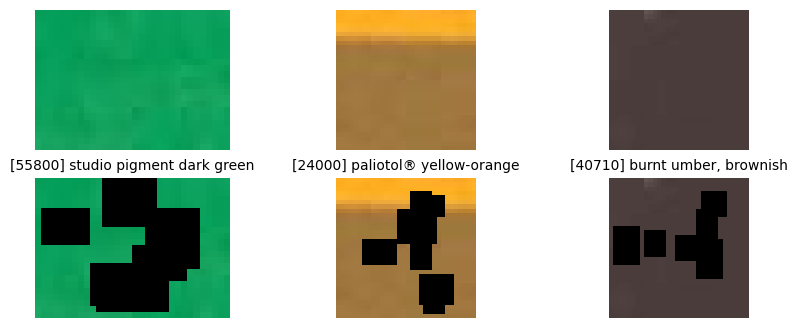

In [5]:
np.random.seed(42)
fig, ax = plt.subplots(2, 3, figsize=(10, 4))
for i, (_, row) in enumerate(df.sample(3, random_state=0).iterrows()):
    image = np.copy(row['sample'])
    ax[0, i].imshow(image)

    # add erosion
    image = erose_image(image)
    ax[1, i].imshow(image)

    # plot settings
    ax[0, i].set_title(row[target], {'fontsize': 10}, y=-0.2)
    ax[0, i].axis('off')
    ax[1, i].axis('off')

In [6]:
tqdm.pandas()
cosine_similarities = df['sample'].progress_apply(
    lambda image: cosine_similarity(
        [features_extractor(image).to_list()], [features_extractor(erose_image(image)).to_list()]
    )[0][0]
)

  0%|          | 0/22749 [00:00<?, ?it/s]

In [7]:
sim_mean = cosine_similarities.mean()
sim_std = cosine_similarities.std()
print(f'{sim_mean = :.2f}\n{sim_std = :.2f}')

sim_mean = 0.70
sim_std = 0.33
